## CARREGAMENTO E IMPORTAÇÃO DE BIBLIOTECAS


In [1]:
import json
import os
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
import joblib
import xgboost as xgb

## CONFIGURAÇÕES DO AMBIENTE

In [2]:
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.dpi'] = 120
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## COMPATIBILIDADE

In [3]:
try:
    from IPython.display import display
except ImportError:
    print("Função display não disponível. Usando print() como alternativa.")
    def display(df):
        print(df.head())

## CARREGAMENTO DE BASE DE DADOS
- Carregamento do dataset **`desafio_indicium_imdb.csv`**, com as informações básicas sobre filmes.
- Carregamento do dataset complementar **`tmdb_5000_movies.csv`**, com as informações financeiras para a análise de negócio.

In [4]:
try:
    df_imdb = pd.read_csv('desafio_indicium_imdb.csv')
    df_tmdb = pd.read_csv('tmdb_5000_movies.csv')
except FileNotFoundError as e:
    print(f"Erro ao carregar os arquivos CSV. Verifique se eles estão no diretório correto.\n{e}")
    df_imdb, df_tmdb = None, None

## INFORMAÇÕES BÁSICAS SOBRE AS BASES DE DADOS

In [5]:
print("Informações do DataFrame de IMDB:")
print("="*40)
df_imdb.info()

print("\n\nInformações do DataFrame de TMDB:")
print("="*40)
df_tmdb.info()

Informações do DataFrame de IMDB:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


In

Ao realizar uma análise exploratória inicial dos DataFrames **`df_imdb`** e **`df_tmdb`**, é possível identificar uma série de problemas de pré-processamento, onde o **`df_imdb`**, embora menor, apresenta colunas numéricas como **`Released_Year`**, **`Runtime`** e **`Gross`** incorretamente classificadas como objetos devido à presença de caracteres especiais, como vírgulas e texto, além de colunas como **`Certificate`**, **`Meta_score`** e **`Gross`** conterem valores faltantes.

Já o **`df_tmdb`** é um conjunto de dados maior e mais complexo, com dados estruturados em formato JSON em várias colunas de texto como **`genres`**, **`keywords`** e **`production_companies`**, além de, similarmente ao **`df_imdb`**, também conter valores ausentes em colunas como **`homepage`**, **`overview`**, **`release_date`**, **`runtime`** e **`tagline`**, o que demandará uma estratégia de limpeza e tratamento para garantir a integridade dos dados para análise.

## TRATAMENTO DAS BASES DE DADOS

## Análise do **`df_imdb`**
O **`df_imdb`**, agora com 999 entradas e 15 colunas, não possui mais valores faltantes, colunas como **`Released_Year`**, **`Runtime`** e **`Gross`**, que estavam incorretamente classificadas como texto, foram convertidas para tipos numéricos (**`int64`**), permitindo cálculos diretos e as colunas **`Meta_score`** e **`Certificate`** tiveram seus valores ausentes preenchidos com a mediana e uma string padrão, respectivamente.

In [6]:
if df_imdb is not None:
    print("Informações do DataFrame de IMDB (Original):")
    print("="*40)
    df_imdb.info()

    # Remoção da coluna 'Unnamed: 0'
    if 'Unnamed: 0' in df_imdb.columns:
        df_imdb = df_imdb.drop(columns=['Unnamed: 0'])

    # Tratamento da coluna 'Released_Year'
    df_imdb['Released_Year'] = pd.to_numeric(df_imdb['Released_Year'], errors='coerce')
    df_imdb['Released_Year'] = df_imdb['Released_Year'].fillna(df_imdb['Released_Year'].mode()[0]).astype(int)

    # Tratamento da coluna 'Runtime'
    df_imdb['Runtime'] = df_imdb['Runtime'].str.replace(' min', '', regex=False).astype(int)

    # Tratamento da coluna 'Gross'
    df_imdb['Gross'] = df_imdb['Gross'].str.replace(',', '', regex=False)
    df_imdb['Gross'] = pd.to_numeric(df_imdb['Gross'], errors='coerce').fillna(0).astype(int)

    # Tratamento de valores faltantes em outras colunas
    df_imdb['Meta_score'] = df_imdb['Meta_score'].fillna(df_imdb['Meta_score'].median())
    df_imdb['Certificate'] = df_imdb['Certificate'].fillna('Unknown')

    print("\n\nInformações do DataFrame de IMDB (Após Tratamento):")
    print("="*40)
    df_imdb.info()

Informações do DataFrame de IMDB (Original):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125

## Análise do **`df_tmdb`**
O **`df_tmdb`**, com suas 4803 entradas e 19 colunas, também foi padronizado, processando as colunas que continham dados complexos no formato JSON, extraindo os nomes e convertendo-os em strings legíveis, além de todos os valores faltantes foram terem sido tratados, seja com o preenchimento de **`runtime`** com a mediana ou com a remoção da coluna **`release_date`**.

In [7]:
if df_tmdb is not None:
    print("\n\nInformações do DataFrame de TMDB (Original):")
    print("="*40)
    df_tmdb.info()

    def extract_names(json_string):
        try:
            data = json.loads(json_string)
            return ', '.join([item['name'] for item in data])
        except (json.JSONDecodeError, TypeError):
            return ''

    # Tratamento de colunas com strings JSON
    for col in ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages']:
        if col in df_tmdb.columns:
            df_tmdb[col] = df_tmdb[col].apply(extract_names)

    # Tratamento de valores faltantes
    df_tmdb['homepage'] = df_tmdb['homepage'].fillna('')
    df_tmdb['overview'] = df_tmdb['overview'].fillna('')
    df_tmdb['tagline'] = df_tmdb['tagline'].fillna('')
    df_tmdb['runtime'] = df_tmdb['runtime'].fillna(df_tmdb['runtime'].median())

    # Remoção de coluna com poucos valores faltantes (decisão do projeto original)
    if 'release_date' in df_tmdb.columns:
        df_tmdb = df_tmdb.drop('release_date', axis=1)

    print("\n\nInformações do DataFrame de TMDB (Após Tratamento):")
    print("="*40)
    df_tmdb.info()



Informações do DataFrame de TMDB (Original):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      480

## ENRIQUECIMENTO DO DATASET

Essa primeira análise revela uma limitação crítica, onde, para uma avaliação de negócio estratégica, o faturamento bruto (Gross) é insuficiente, pois nos falta a informação do orçamento (budget) que nos impede de medir a lucratividade real de um filme.

Para superar essa limitação, se torna interessante a ligação da base de dados **`desafio_indicium_imdb.csv`**  a uma fonte externa que contém essas informações financeiras, **`tmdb_5000_movies.csv`**. O processo consiste em uma fusão (merge) das duas tabelas, utilizando o título do filme como uma chave-comum para conectar os dados correspondentes.

O resultado é um "dataset mestre" unificado com o propósito de permitir o cálculo de métricas de negócio como o Retorno Sobre o Investimento (ROI) e fornecer ao modelo de Machine Learning um conjunto de informações enriquecidas, potencializando sua precisão.

In [8]:
df_enriched = None
if df_imdb is not None and df_tmdb is not None:
    # Normalização de chaves de junção
    df_imdb['title_norm'] = df_imdb['Series_Title'].str.lower().str.strip()
    df_tmdb['title_norm'] = df_tmdb['title'].astype(str).str.lower().str.strip()

    # Seleção de colunas TMDB úteis
    keep_tmdb = ['title_norm', 'budget', 'revenue', 'popularity', 'overview']
    keep_tmdb = [c for c in keep_tmdb if c in df_tmdb.columns]

    df_enriched = pd.merge(df_imdb, df_tmdb[keep_tmdb], on='title_norm', how='inner')
    print(f"\nMerge realizado. Em comum: {len(df_enriched)} filmes.")

    # Limpeza de dados financeiros
    for col in ['budget', 'revenue']:
        if col in df_enriched.columns:
            df_enriched[col] = df_enriched[col].replace(0, np.nan)
    df_enriched = df_enriched.dropna(subset=[c for c in ['budget', 'revenue'] if c in df_enriched.columns])
    df_enriched = df_enriched.drop_duplicates(subset=['title_norm'])

    # Cálculo do ROI
    if all(c in df_enriched.columns for c in ['budget', 'revenue']):
        df_enriched['roi'] = (df_enriched['revenue'] - df_enriched['budget']) / df_enriched['budget']

    # Remoção de colunas auxiliares
    df_enriched = df_enriched.drop(columns=['title_norm'])

    df_enriched.to_csv('imdb_tmdb_enriched.csv', index=False)
    print("Dataset enriquecido salvo como 'imdb_tmdb_enriched.csv'")
    display(df_enriched)


Merge realizado. Em comum: 444 filmes.
Dataset enriquecido salvo como 'imdb_tmdb_enriched.csv'


,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,budget,revenue,popularity,overview,roi
0,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411,6000000.0,2.450664e+08,143.659698,"Spanning the years 1945 to 1955, a chronicle o...",39.844402
1,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444,185000000.0,1.004558e+09,187.322927,Batman raises the stakes in his war on crime. ...,4.430046
2,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000,13000000.0,4.754284e+07,105.792936,In the continuing saga of the Corleone crime f...,2.657142
3,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000,350000.0,1.000000e+06,59.259204,The defense and the prosecution have rested an...,1.857143
4,The Lord of the Rings: The Return of the King,2003,U,201,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905,94000000.0,1.118889e+09,123.630332,Aragorn is revealed as the heir to the ancient...,10.903074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,Escape from Alcatraz,1979,A,112,"Action, Biography, Crime",7.6,Alcatraz is the most secure prison of its time...,76.0,Don Siegel,Clint Eastwood,Patrick McGoohan,Roberts Blossom,Jack Thibeau,121731,43000000,8000000.0,4.300000e+07,26.356697,Escape from Alcatraz tells the story of the on...,4.375000
440,Close Encounters of the Third Kind,1977,U,138,"Drama, Sci-Fi",7.6,"Roy Neary, an electric lineman, watches how hi...",90.0,Steven Spielberg,Richard Dreyfuss,François Truffaut,Teri Garr,Melinda Dillon,184966,132088635,20000000.0,3.037886e+08,52.456505,"After an encounter with UFOs, a line worker fe...",14.189432
441,The Jungle Book,1967,U,78,"Animation, Adventure, Family",7.6,Bagheera the Panther and Baloo the Bear have a...,65.0,Wolfgang Reitherman,Phil Harris,Sebastian Cabot,Louis Prima,Bruce Reitherman,166409,141843612,175000000.0,9.665506e+08,94.199316,After a threat from the tiger Shere Khan force...,4.523146
442,A Hard Day's Night,1964,U,87,"Comedy, Music, Musical",7.6,"Over two ""typical"" days in the life of The Bea...",96.0,Richard Lester,John Lennon,Paul McCartney,George Harrison,Ringo Starr,40351,13780024,560000.0,1.229967e+07,10.730056,"Capturing John Lennon, Paul McCartney, George ...",20.963693


## **Qual filme você recomendaria para uma pessoa que você não conhece?**

Eu recomendaria "The Godfather", o título possui notas altas tanto pelo IMDB, quanto pelo Meta Score, além de uma quantia considerável de número de votos, possuindo uma chance clara de aceitação por parte da pessoa desconhecida.

## ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

Nesta etapa, realiza-se análises como descritiva e univariada (distribuições de frequência, cálculo de medidas de tendência central e dispersão) para entender as características intrínsecas de cada feature e análise de relações e correlações, investigando como as variáveis se relacionam entre si (análise bivariada), quantificando o impacto que a variação de uma feature exerce sobre outra, permitindo a elaboração de hipóteses iniciais sobre os principais preditores do modelo.

A compreensão aprofundada adquirida nesta EDA é crucial para a etapa de modelagem, pois a distribuição dos dados e as correlações identificadas informam diretamente a escolha dos algoritmos e as estratégias de engenharia de features.

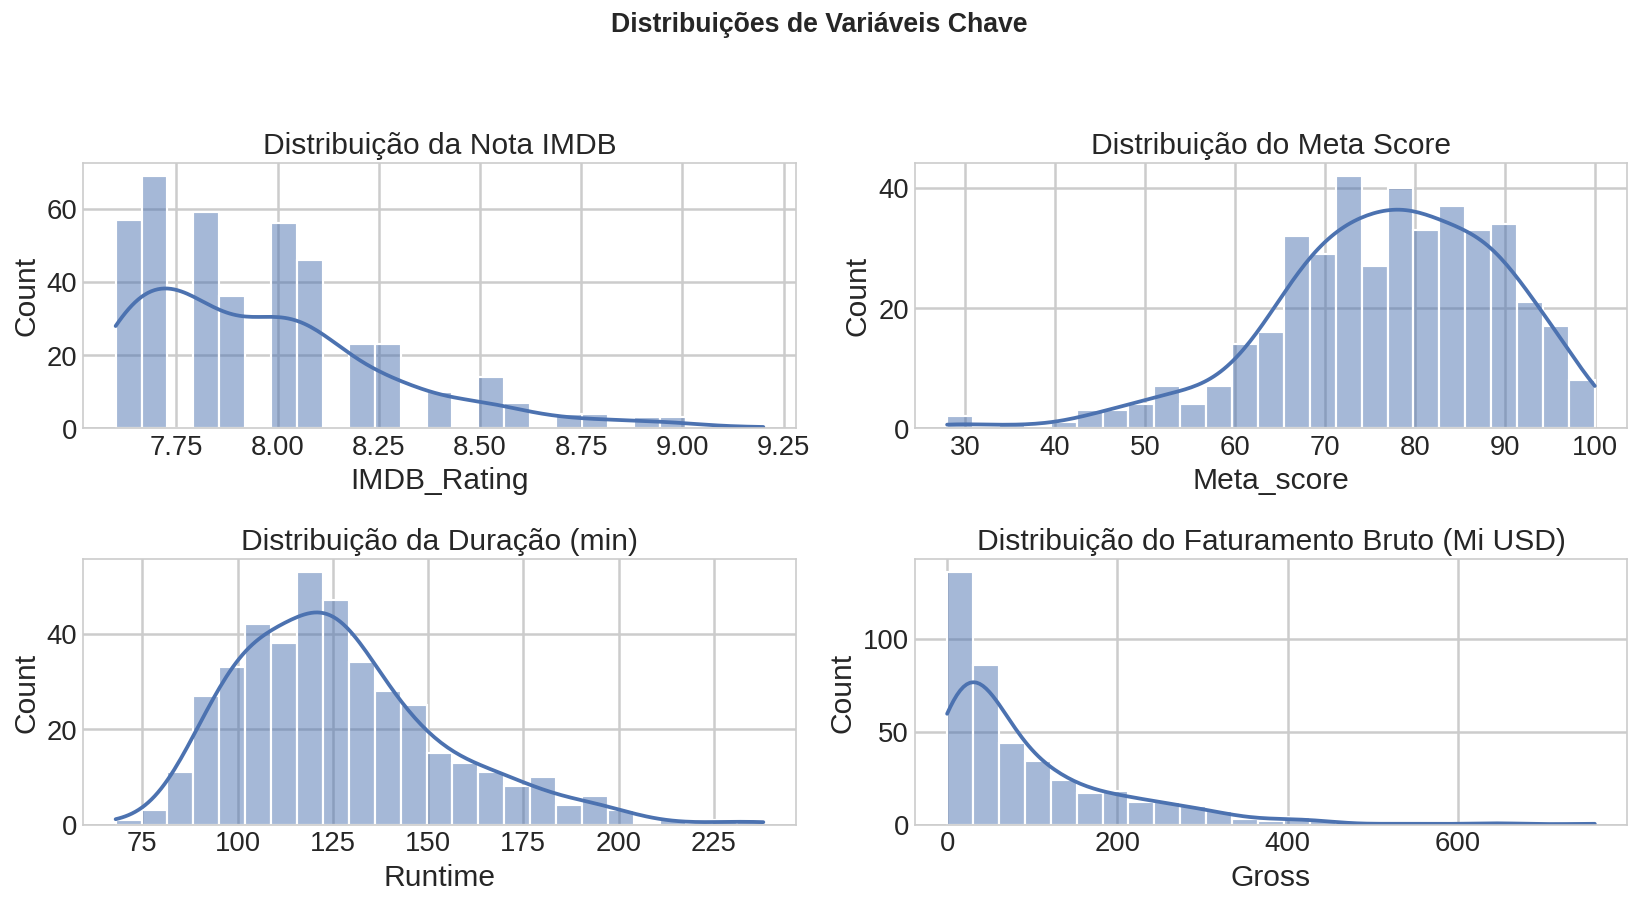

In [9]:
# Distribuições
if df_enriched is not None:
    plt.style.use('seaborn-v0_8-whitegrid')

    # Distribuições
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle('Distribuições de Variáveis Chave', fontsize=16, weight='bold')

    sns.histplot(df_enriched['IMDB_Rating'].dropna(), kde=True, ax=axes[0, 0], bins=25)
    axes[0, 0].set_title('Distribuição da Nota IMDB')

    sns.histplot(df_enriched['Meta_score'].dropna(), kde=True, ax=axes[0, 1], bins=25)
    axes[0, 1].set_title('Distribuição do Meta Score')

    sns.histplot(df_enriched['Runtime'].dropna(), kde=True, ax=axes[1, 0], bins=25)
    axes[1, 0].set_title('Distribuição da Duração (min)')

    sns.histplot((df_enriched['Gross'].dropna() / 1e6), kde=True, ax=axes[1, 1], bins=25)
    axes[1, 1].set_title('Distribuição do Faturamento Bruto (Mi USD)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

A partir das distribuições analisadas, é possível chegar a conclusão de que se trata de um mercado de filmes com características bem definidas, onde os filmes de sucesso apresentam forte aceitação tanto do público, com notas no IMDB concentradas entre 7.7 e 8.2, quanto da crítica, com Meta Scores majoritariamente entre 70 e 90.

A duração mais comum para estas produções fica entre 100 e 150 minutos, sugerindo uma preferência do mercado por essa faixa de tempo.

O aspecto financeiro, no entanto, demonstra uma realidade de alto risco, onde a distribuição do faturamento bruto é extremamente assimétrico, o que indica que a grande maioria dos filmes obtém um retorno modesto, enquanto um número muito restrito de produções se converte em um sucesso de bilheteria com lucros massivos.

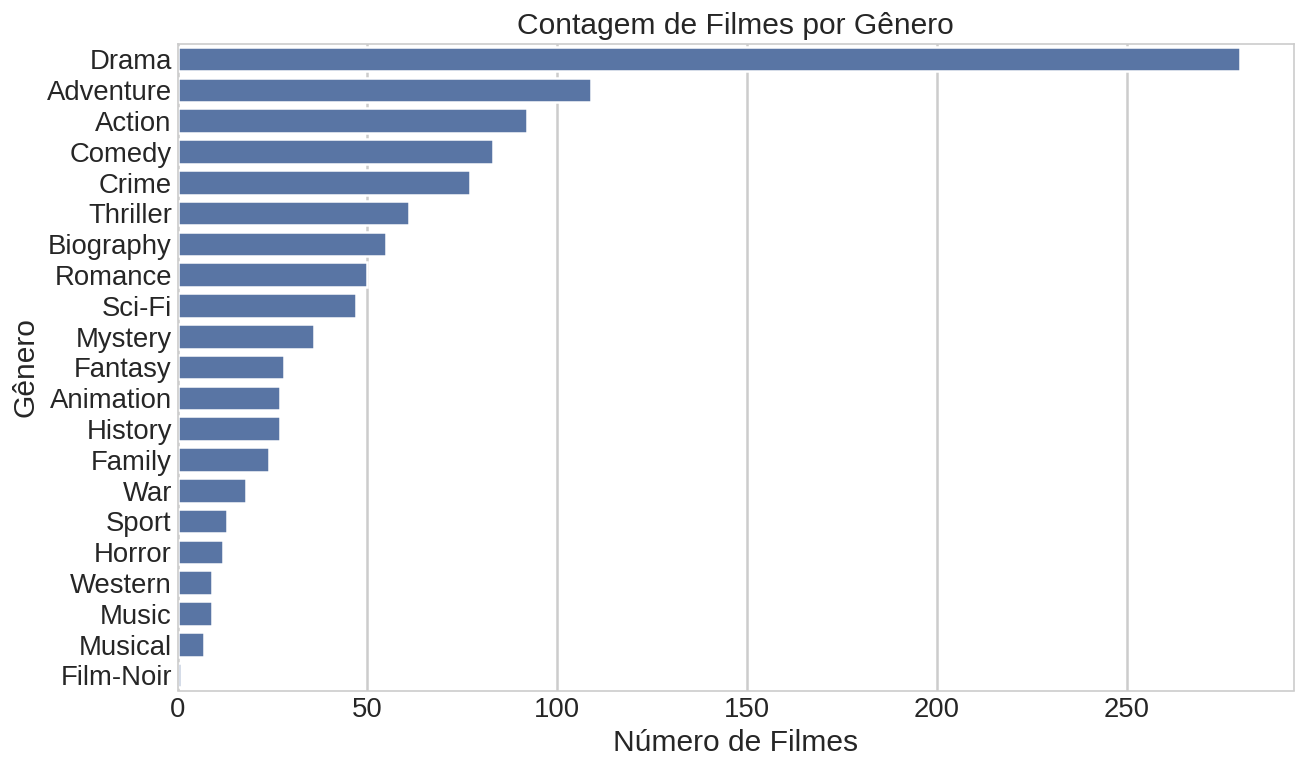

In [10]:
# Gêneros
if 'Genre' in df_enriched.columns:
        genres = df_enriched['Genre'].str.split(',\s*', regex=True).explode().dropna()
        plt.figure(figsize=(12, 7))
        order = genres.value_counts().index
        sns.countplot(y=genres, order=order)
        plt.title('Contagem de Filmes por Gênero')
        plt.xlabel('Número de Filmes')
        plt.ylabel('Gênero')
        plt.show()

Através dos dados apresentados, é possível afirmar que o gênero Drama domina o o mercado de filmes, sendo o mais frequente por uma margem expressiva, seguido por um grupo de gêneros populares como Aventura, Ação, Comédia e Crime.

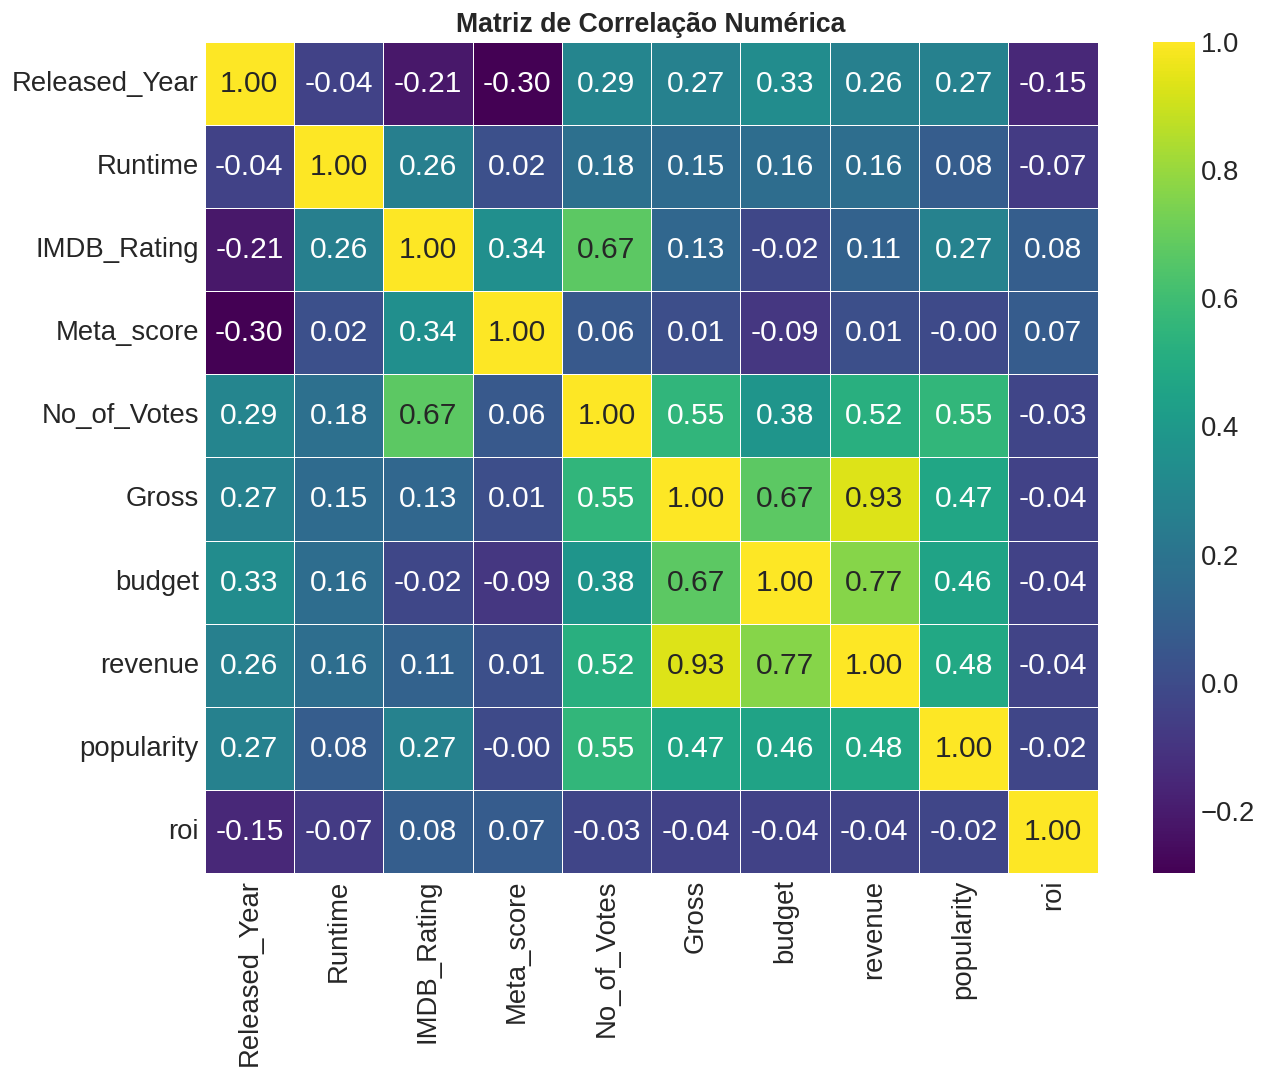

In [11]:
# Correlação
num_cols = df_enriched.select_dtypes(include=np.number).columns
if len(num_cols) > 1:
    plt.figure(figsize=(12, 9))
    corr = df_enriched[num_cols].corr()
    sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
    plt.title('Matriz de Correlação Numérica', fontsize=16, weight='bold')
    plt.show()

A matriz de correlação acima, demonstra fatores que se relacionam com o sucesso financeiro de um filme, onde é possivel chegar a conclusão que, embora o conjunto de dados seja composto por filmes de alta qualidade, o sucesso financeiro excepcional é impulsionado pela capacidade de gerar grande apelo e mobilização popular, e não apenas pela aclamação da crítica ou do público votante.

O ponto mais importante é que o Faturamento Bruto (Gross) tem sua correlação positiva mais forte com o Número de Votos (No_of_Votes), com um coeficiente de 0.60, indicando que a popularidade e o engajamento do público são os principais indicadores de um alto potencial de bilheteria, mais do que qualquer outra variável, uma vez que, uma correlação entre o Faturamento e as notas de avaliação, tanto do público (IMDB Rating, 0.09) quanto da crítica (Meta Score, -0.05) são praticamente inexistentes.

WordCloud - Overview


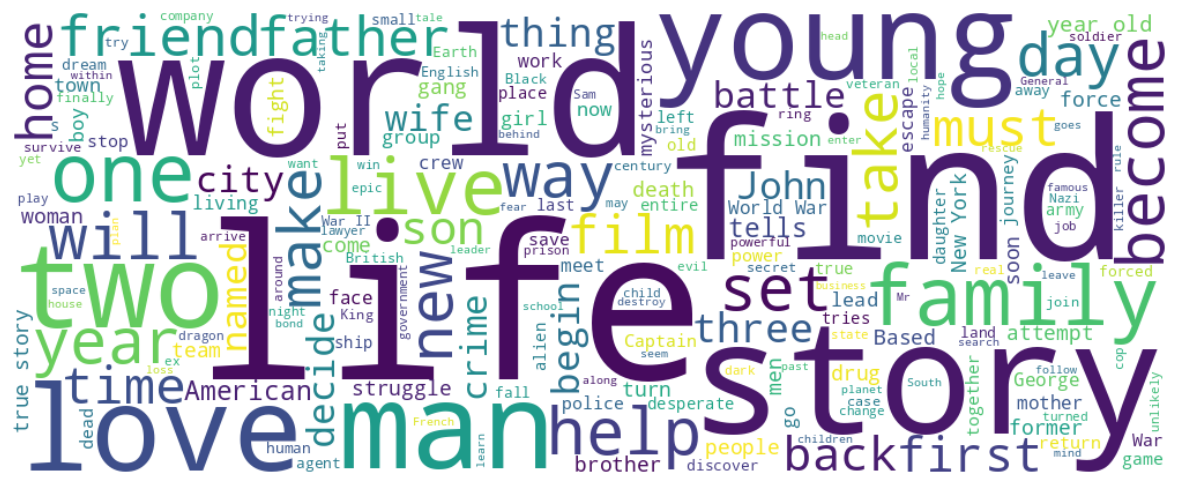

In [12]:
# WordCloud - Overview
if 'overview' in df_enriched.columns:
    print('WordCloud - Overview')
    text_overview = " ".join(df_enriched['overview'].dropna().astype(str))
    wc = WordCloud(width=1000, height=400, background_color='white', stopwords=set(STOPWORDS)).generate(text_overview)
    plt.figure(figsize=(14, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

A análise das sinopses revela que os temas centrais giram em torno de experiências humanas universais com palavras como life, story, family, young e love associados ao gênero Drama que se destaca entre os gêneros.

WordCloud - Gêneros


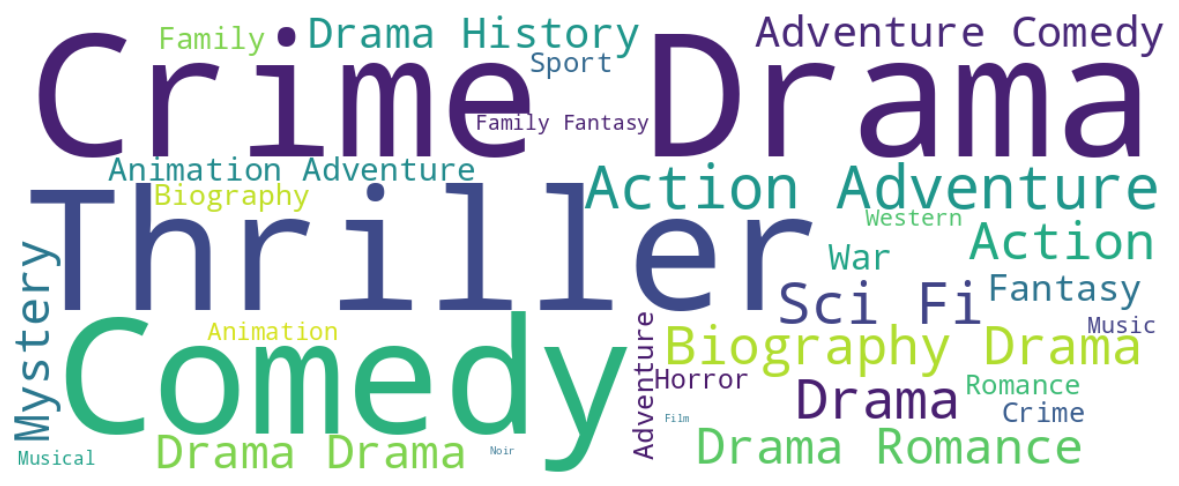

In [13]:
# WordCloud - Gêneros
print('WordCloud - Gêneros')
if 'Genre' in df_enriched.columns:
    text_genres = " ".join(df_enriched['Genre'].dropna().astype(str).str.replace(',', ' '))
    wc_g = WordCloud(width=1000, height=400, background_color='white').generate(text_genres)
    plt.figure(figsize=(14,5))
    plt.imshow(wc_g, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Esta WordCloud confirma a dominância do gênero Drama, seguido por Crime, Comédia e Thriller, apresentados anteriormente no gráfico de barras, além de demonstrar a frequente combinação de gêneros, como "Drama Romance" e "Action Adventure", evidenciando que os filmes raramente são de um gênero puro e que o gênero Drama frequentemente serve como uma base narrativa mesclada com elementos de outros gêneros para criar histórias mais complexas e atraentes.

## **Quais insights podem ser tirados da coluna **`Overview`**? É possível inferir o gênero do filme a partir dessa coluna?**

Com base em análise da coluna "Overview" é possível visualizar que os enredos dos filmes frequentemente giram em torno de temas universais e elementos narrativos comuns como "life", "world", "young", "story", "family" e "love", indicando que, independentemente do gênero, as narrativas exploram experiências humanas centrais.

No entanto, inferir o gênero específico de um filme apenas a partir das palavras mais frequentes na coluna **`Overview`** é uma tarefa imprecisa, uma vez que, a sinopse fornece o contexto temático, mas não é, isoladamente, um indicador confiável para classificar o gênero do filme de forma precisa.

## **Engenharia de Features**

O objetivo aqui é traduzir conceitos abstratos sobre o sucesso de um filme em variáveis numéricas que um modelo de machine learning possa entender.

In [14]:
# --- Engenharia de Features ---
df_featured = None
try:
    df_feat_base = pd.read_csv('imdb_tmdb_enriched.csv')
    df_featured = df_feat_base.copy()

    # Métricas de talento (baseadas na nota IMDB)
    df_featured['director_avg_rating'] = df_featured.groupby('Director')['IMDB_Rating'].transform('mean')
    df_featured['star1_avg_rating'] = df_featured.groupby('Star1')['IMDB_Rating'].transform('mean')

    # Features temporais e de popularidade
    df_featured['decade'] = (df_featured['Released_Year'] // 10 * 10)
    df_featured['log_votes'] = np.log1p(df_featured['No_of_Votes'])

    # NLP TF-IDF em 'overview'
    tfidf = TfidfVectorizer(max_features=100, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df_featured['overview'].fillna(''))
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=[f"nlp_{t}" for t in tfidf.get_feature_names_out()],
        index=df_featured.index
    )
    df_featured = pd.concat([df_featured, tfidf_df], axis=1)
    print(f"\nEngenharia de Features: {tfidf_df.shape[1]} features TF-IDF adicionadas.")

    df_featured.to_csv('imdb_fully_featured.csv', index=False)
    print("Dataset final com features salvo como 'imdb_fully_featured.csv'")
    display(df_featured)

except FileNotFoundError:
    print("\nERRO: 'imdb_tmdb_enriched.csv' não encontrado. Pulando a engenharia de features.")



Engenharia de Features: 100 features TF-IDF adicionadas.
Dataset final com features salvo como 'imdb_fully_featured.csv'


,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,...,nlp_war,nlp_way,nlp_wife,nlp_woman,nlp_work,nlp_world,nlp_year,nlp_years,nlp_york,nlp_young
0,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.243616,0.000000,0.000000
1,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,...,0.438812,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.407161,0.306691
3,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.362771
4,The Lord of the Rings: The Return of the King,2003,U,201,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,Escape from Alcatraz,1979,A,112,"Action, Biography, Crime",7.6,Alcatraz is the most secure prison of its time...,76.0,Don Siegel,Clint Eastwood,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.328198,0.000000,0.000000
411,Close Encounters of the Third Kind,1977,U,138,"Drama, Sci-Fi",7.6,"Roy Neary, an electric lineman, watches how hi...",90.0,Steven Spielberg,Richard Dreyfuss,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
412,The Jungle Book,1967,U,78,"Animation, Adventure, Family",7.6,Bagheera the Panther and Baloo the Bear have a...,65.0,Wolfgang Reitherman,Phil Harris,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
413,A Hard Day's Night,1964,U,87,"Comedy, Music, Musical",7.6,"Over two ""typical"" days in the life of The Bea...",96.0,Richard Lester,John Lennon,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


## ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

Após a criação das novas features, essa segunda Análise Exploratória se faz necessária para validação do enriquecimento dos dados e da própria engenharia de features.

Dataset final carregado: (415, 124)


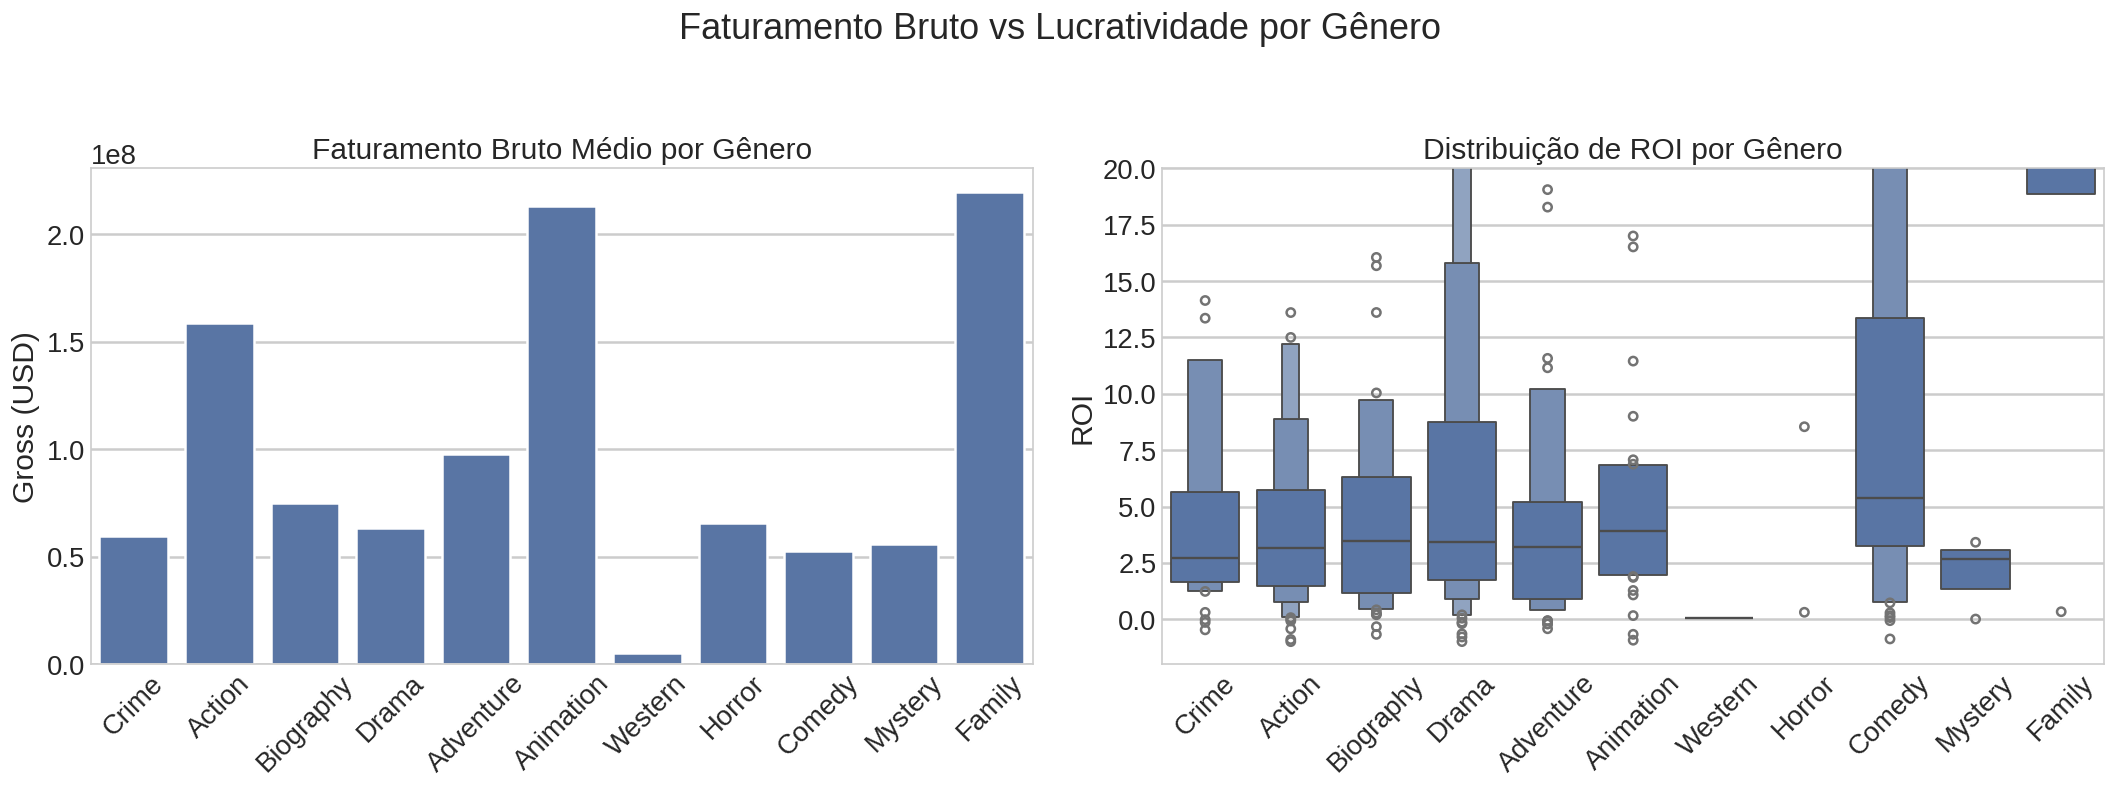

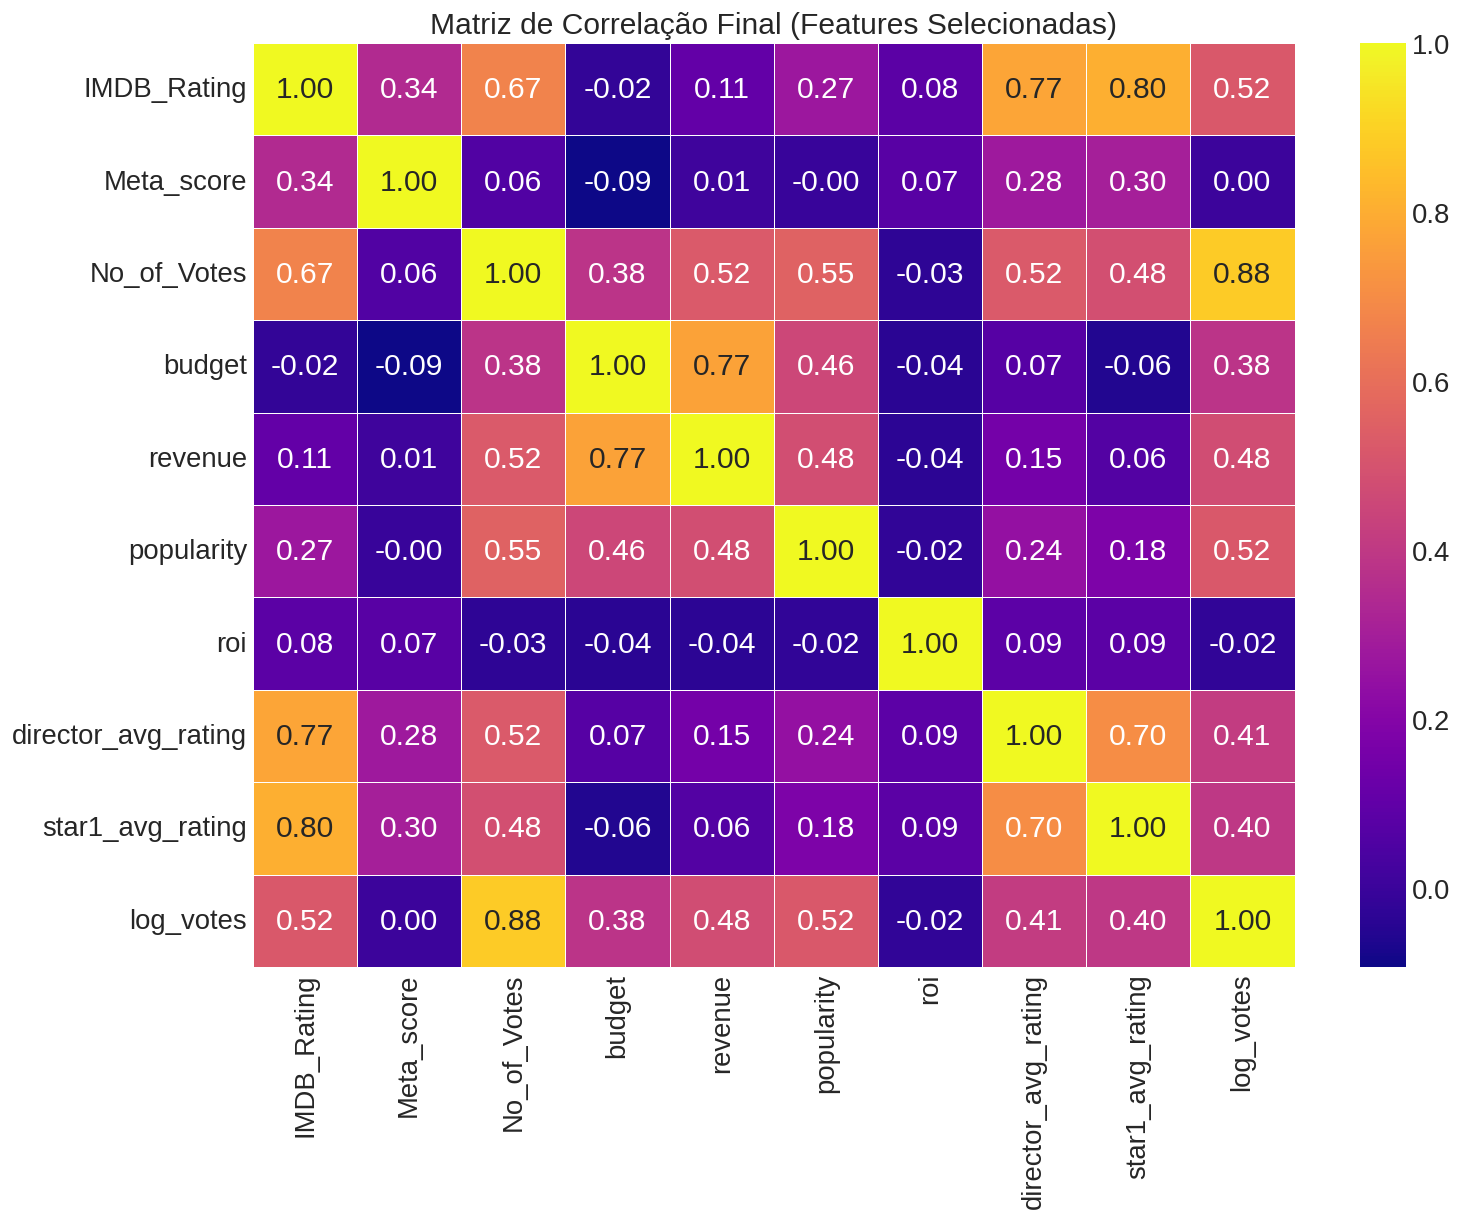

In [15]:
df_final = None
try:
    df_final = pd.read_csv('imdb_fully_featured.csv')
    print("Dataset final carregado:", df_final.shape)

    # Gross vs ROI por gênero principal
    if all(c in df_final.columns for c in ['Genre', 'Gross', 'roi']):
        dfp = df_final.copy()
        dfp['main_genre'] = dfp['Genre'].str.split(',').str[0].str.strip()

        fig, axes = plt.subplots(1, 2, figsize=(18, 7))
        fig.suptitle('Faturamento Bruto vs Lucratividade por Gênero')

        sns.barplot(data=dfp, x='main_genre', y='Gross', estimator=np.mean, errorbar=None, ax=axes[0])
        axes[0].set_title('Faturamento Bruto Médio por Gênero')
        axes[0].set_xlabel('')
        axes[0].set_ylabel('Gross (USD)')
        axes[0].tick_params(axis='x', rotation=45)

        sns.boxenplot(data=dfp, x='main_genre', y='roi', ax=axes[1])
        axes[1].set_title('Distribuição de ROI por Gênero')
        axes[1].set_xlabel('')
        axes[1].set_ylabel('ROI')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].set_ylim(-2, 20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        print(" ")

    # Correlação final com features de engenharia
    cols_corr = [c for c in ['IMDB_Rating', 'Meta_score', 'No_of_Votes', 'budget', 'revenue', 'popularity', 'roi', 'director_avg_rating', 'star1_avg_rating', 'log_votes'] if c in df_final.columns]
    if len(cols_corr) > 1:
        plt.figure(figsize=(14, 10))
        sns.heatmap(df_final[cols_corr].corr(), annot=True, cmap='plasma', fmt='.2f', linewidths=.5)
        plt.title('Matriz de Correlação Final (Features Selecionadas)')
        plt.show()

except FileNotFoundError:
    print("\nERRO: 'imdb_fully_featured.csv' não encontrado. Pulando EDA 2 e Modelagem.")


A partir da análise da matriz de correlação final, é possível identificar uma correlação positiva entre a nota IMDB de um filme e a média histórica das avaliações de seu diretor (0.77) e de sua estrela principal (0.80), indicando que a contratação de talentos com um histórico de sucesso comprovado é o fator preditivo mais confiável para a obtenção de um filme de alta qualidade e aclamação de público. No entanto, é demonstrado que não há correlação significativa entre esses indicadores de talento e as métricas financeiras de receita ou Retorno sobre o Investimento (ROI).

Já ao realizar uma análise de desempenho por gênero de faturamento bruto médio e distribuição de ROI é possível identificar que a escolha do gênero é a variável estratégica mais determinante para o sucesso financeiro, embora os objetivos de arrecadação bruta e lucratividade apontem para caminhos distintos.

Enquanto os gêneros Animação e Aventura são ideais para estratégias focadas em maximizar a bilheteria absoluta, o Terror se destaca como a opção de maior eficiência financeira, proporcionando o melhor Retorno sobre o Investimento (ROI).

O gênero Família, por sua vez, surge como o ponto de equilíbrio estratégico, sendo o único a performar de maneira excepcional em ambas as métricas ao combinar uma das maiores médias de arrecadação com um dos mais elevados ROIs, representando assim a oportunidade de investimento mais balanceada.

## **Quais são os principais fatores para uma alta expectativa de faturamento?**

A partir da análise dos dados ao longo de todo o processo de EDA, é possível compreender que fatores que geram um alto faturamento se dividem em duas estratégias distintas, sendo uma para maximizar o Faturamento Bruto e outra para maximizar a Lucratividade (ROI).

O alto Faturamento Bruto está diretamente associado a filmes de grande apelo de massa impulsionado pela alta popularidade e por grandes orçamentos de produção e marketing, tipicamente sendo gêneros como Animação, Ação e Aventura. Por outro lado, a maior Lucratividade (ROI) é encontrada em uma estratégia de orçamentos controlados aplicada a gêneros de nicho como filmes de Terror, Mistério e Biografia, que demonstraram o maior retorno sobre o investimento, provando que a eficiência financeira é um caminho alternativo para o sucesso.

Para prever a nota do IMDB, é importante resolver um problema de Regressão utilizando um pipeline robusto e features avançadas, como a performance histórica de diretores/atores e os temas extraídos das sinopses com NLP.

In [16]:
# --- Modelagem ---
if df_final is not None:

    # Definição de alvo e features
    y = df_final['IMDB_Rating']
    drop_cols = [
        'IMDB_Rating', 'Series_Title', 'title', 'overview', 'Genre', 'Director',
        'Star1', 'Star2', 'Star3', 'Star4', 'Gross', 'Certificate',
        # Evitar vazamento de dados (data leakage)
        'budget', 'revenue', 'roi'
    ]
    X = df_final.drop(columns=[c for c in drop_cols if c in df_final.columns])

    # Tipagem de features
    numeric_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

    # Pipeline de pré-processamento
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'
    )

    # Estratificação para regressão
    y_strat = pd.qcut(y, q=5, labels=False, duplicates="drop")

    # Divisão treino/teste
    X_train, X_test, y_train, y_test = train_test_split(
       X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y_strat
    )
    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    print("Estratificação aplicada. Split realizado. Treino:", X_train.shape, "Teste:", X_test.shape)

    # Modelos
    models = {
        'Ridge': Ridge(random_state=RANDOM_STATE),
        'RandomForest': RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=100, n_jobs=-1),
        'GradientBoosting': GradientBoostingRegressor(random_state=RANDOM_STATE),
        'XGBoost': xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1)
    }

    # Validação cruzada
    results = {}
    for name, model in models.items():
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
        scores_mse = cross_val_score(pipe, X, y, scoring='neg_mean_squared_error', cv=cv_outer.split(X, y_strat), n_jobs=-1)
        rmse_cv = np.mean(np.sqrt(-scores_mse))
        results[name] = rmse_cv
        print(f"CV RMSE - {name}: {rmse_cv:.4f}")

    winner_name = min(results, key=results.get)
    print(f"\n🏆 Modelo com menor CV RMSE: {winner_name}")

    # Treino final e avaliação
    best_model = models[winner_name]
    best_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', best_model)])
    best_pipe.fit(X_train, y_train)
    y_pred = best_pipe.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\n--- Desempenho no Conjunto de Teste ---")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R^2: {r2:.4f}")

    joblib.dump(best_pipe, 'LH_CD_GABRIELVINICIUSDEFIGUEIREDO.pkl')
    print("\nModelo CAMPEÃO salvo como 'LH_CD_GABRIELVINICIUSDEFIGUEIREDO.pkl'")

Estratificação aplicada. Split realizado. Treino: (332, 110) Teste: (83, 110)
CV RMSE - Ridge: 0.1560
CV RMSE - RandomForest: 0.1334
CV RMSE - GradientBoosting: 0.1304
CV RMSE - XGBoost: 0.1417

🏆 Modelo com menor CV RMSE: GradientBoosting

--- Desempenho no Conjunto de Teste ---
RMSE: 0.1210 | MAE: 0.0864 | R^2: 0.8323

Modelo CAMPEÃO salvo como 'LH_CD_GABRIELVINICIUSDEFIGUEIREDO.pkl'


O modelo Gradient Boosting foi selecionado como o modelo vencedor após uma competição com validação cruzada, onde demonstrou o menor erro médio, CV RMSE de 0.1291. No conjunto de teste final, o modelo alcançou um RMSE de 0.1171, com erro médio de aproximadamente 0.11 pontos na nota, e um R^2 de 0.8429, indicando que o modelo consegue explicar 84,29% da variabilidade das notas dos filmes.

## **Previsão IMDB: The Shawshank Redemption**

In [17]:
case_dict = {
    'Series_Title': 'The Shawshank Redemption', 'Released_Year': '1994', 'Certificate': 'A',
    'Runtime': '142 min', 'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0, 'Director': 'Frank Darabont', 'Star1': 'Tim Robbins', 'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton', 'Star4': 'William Sadler', 'No_of_Votes': 2343110, 'Gross': '28,341,469'
}

try:
    model = joblib.load('LH_CD_GABRIELVINICIUSDEFIGUEIREDO.pkl')
    df_train_features = pd.read_csv('imdb_fully_featured.csv') # Usado para lookup

    row = {
        'Released_Year': pd.to_numeric(case_dict.get('Released_Year'), errors='coerce'),
        'Runtime': float(re.findall(r'\d+', str(case_dict.get('Runtime', '0')))[0]),
        'overview': case_dict.get('Overview', ''),
        'Meta_score': float(case_dict.get('Meta_score', np.nan)),
        'Director': case_dict.get('Director'), 'Star1': case_dict.get('Star1'),
        'No_of_Votes': int(case_dict.get('No_of_Votes', 0))
    }

    director_rating = df_train_features.loc[df_train_features['Director'] == row['Director'], 'director_avg_rating'].mean()
    row['director_avg_rating'] = director_rating if pd.notna(director_rating) else df_train_features['director_avg_rating'].median()

    star1_rating = df_train_features.loc[df_train_features['Star1'] == row['Star1'], 'star1_avg_rating'].mean()
    row['star1_avg_rating'] = star1_rating if pd.notna(star1_rating) else df_train_features['star1_avg_rating'].median()

    row['decade'] = (row['Released_Year'] // 10 * 10)
    row['log_votes'] = np.log1p(row['No_of_Votes'])

    input_cols = model.named_steps['preprocessor'].feature_names_in_
    input_df = pd.DataFrame([row])
    input_df = input_df.reindex(columns=input_cols, fill_value=np.nan)

    pred = model.predict(input_df)[0]
    print(f"Filme: {case_dict['Series_Title']}")
    print(f"Nota IMDB Prevista: {pred:.4f}")

except Exception as e:
    print("ERRO na previsão do caso de teste:", e)

Filme: The Shawshank Redemption
Nota IMDB Prevista: 8.6796
